#### LangChain vs LangGraph (feat. LangGraph 개념 설명)
* LangGraph의 개념과 주요 기능을 이해하고, 차이점을 비교합니다.

In [54]:
# poetry add langgraph

In [55]:
from dotenv import load_dotenv
import os

load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
print(OPENAI_API_KEY[:2])

UPSTAGE_API_KEY = os.getenv("UPSTAGE_API_KEY")
print(UPSTAGE_API_KEY[30:])

sk
z6


In [56]:
# from langchain_openai import ChatOpenAI

# llm = ChatOpenAI(model='gpt-4o-mini') # 테스트의 경우에는 작은 모델을 사용합니다

from langchain_upstage import ChatUpstage
llm = ChatUpstage(
        model="solar-pro",
        base_url="https://api.upstage.ai/v1",
        temperature=0.5
    )
print(llm)

query = 'LangGraph는 무엇인가요?'
ai_msg = llm.invoke(query)
print(ai_msg.content)

client=<openai.resources.chat.completions.completions.Completions object at 0x000002A90D3EB650> async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x000002A90D3E8BC0> model_name='solar-pro' temperature=0.5 model_kwargs={} upstage_api_key=SecretStr('**********') upstage_api_base='https://api.upstage.ai/v1'
**LangGraph**는 **Language Model(LM)과 그래프 기반 상태 관리를 결합한 프레임워크**로, 복잡한 멀티턴 대화나 상태 유지가 필요한 애플리케이션(예: 챗봇, 워크플로우 자동화, 게임 대화 시스템)을 구축하기 위해 설계되었습니다.  

### 주요 특징:
1. **그래프 기반 상태 관리**  
   - 대화를 **노드(Node)**와 **엣지(Edge)**로 구성된 그래프로 표현합니다.  
     - **노드**: 특정 상태(예: "사용자 인증 완료", "주문 확인 중")를 나타냅니다.  
     - **엣지**: 상태 전이 조건(예: "예" 입력 시 다음 단계로 이동)을 정의합니다.  
   - LLM의 출력을 기반으로 동적으로 경로를 선택할 수 있습니다.

2. **LLM과의 통합**  
   - LangChain, LLaMA, GPT 등 다양한 언어 모델과 연동 가능합니다.  
   - 사용자 입력을 LLM이 처리하고, 그래프 엔진이 상태를 추적하며 흐름을 제어합니다.

3. **확장성**  
   - 커스텀 노드/엣지를 추가해 복잡한 워크플로우(예: 결제 프로세스, 고객 지원 티켓 시스템)를 구축할 수 있습니다.  
   - 메모리 관리, 도구 호출(예: 외부 API 연동) 등의 기능을 지원합니다.

4. **사용 사례** 

#### LangGraph의 기본개념
* `state`는 LangGraph 에이전트의 state를 나타내는 데이터 구조입니다.
* `state`는 `TypedDict`를 사용하여 정의되며, 이는 Python의 타입 힌팅을 통해 구조를 명확히 합니다.
    * 간단하게 `messages`라는 필드만 있습니다.
    * 필요에 따라 다양한 값들을 활용할 수 있습니다.
* `state`는 에이전트의 동작을 결정하는 데 사용되며, 각 노드에서 state를 업데이트하거나 참조할 수 있습니다.
* `state`는 LangGraph의 노드 간에 전달되며, 에이전트의 state 전이를 관리합니다.

In [57]:
from typing import Annotated # 타입 힌트를 사용하기 위해 
from typing_extensions import TypedDict # 구조화된 딕셔너리 타입을 정의하기 위해 

from langgraph.graph.message import add_messages 
from langchain_core.messages import AnyMessage # LangChain에서 사용하는 모든 종류의 메시지(예: HumanMessage, AIMessage, ToolMessage)

# AgentState는 에이전트의 현재 상태를 나타내는 딕셔너리 타입을 정의합니다.
# TypedDict를 사용하면 딕셔너리가 어떤 키와 값 타입을 가져야 하는지 명확하게 지정할 수 있습니다.
class AgentState(TypedDict):
    # 'messages' 키는 에이전트의 대화 기록을 저장합니다.
    # 이 목록에는 LangChain 메시지 객체(AnyMessage)가 들어갑니다.
    # LangGraph가 이 상태를 처리할 때, 새로운 메시지가 추가되면
    # 기존 메시지 목록의 끝에 자동으로 추가되도록(append) 설정합니다.
    messages: list[Annotated[AnyMessage, add_messages]]

- 위에 선언한 `AgentState`를 활용하여 `StateGraph`를 생성합니다.

In [58]:
from langgraph.graph import StateGraph

graph_builder = StateGraph(AgentState)
print(type(graph_builder))

<class 'langgraph.graph.state.StateGraph'>


- `graph`에 추가할 `node`를 생성합니다
-  `node`는 LangGraph에서 실행되는 개별적인 작업 단위를 의미합니다. 
    - 각 노드는 특정 기능을 수행하는 독립적인 컴포넌트로, 예를 들어 텍스트 생성, 데이터 처리, 또는 의사 결정과 같은 작업을 담당할 수 있습니다.
    - `node`는 기본적으로 함수(function)로 정의되고, 뒤에서 다루지만 다른 에이전트(agent)를 활용할 수도 있습니다

In [59]:
# Node 역할을 하는 함수의 인자로 state 객체를 사용함  LLM을 호출하는 노드
def generate(state: AgentState) -> AgentState:
    """
    `generate` 노드는 사용자의 질문을 받아서 응답을 생성하는 노드입니다.
    """
    messages = state['messages']
    ai_message = llm.invoke(messages)
    return {'messages': [ai_message]}

- `node`를 생성한 후에 `edge`로 연결합니다
- `edge`는 노드들 사이의 연결을 나타내며, 데이터와 제어 흐름의 경로를 정의합니다. 
    - 엣지를 통해 한 노드의 출력이 다음 노드의 입력으로 전달되어, 전체적인 워크플로우가 형성됩니다.
    - `node`와 `edge`의 조합은 방향성 그래프(Directed Graph)를 형성하며, 이를 통해 복잡한 AI 에이전트의 행동 흐름을 구조화할 수 있습니다

In [60]:
# LLM을 호출하는 generate 함수를 Node로 추가함
graph_builder.add_node('generate', generate)

- 모든 그래프는 `START(시작)`와 `END(종료)`가 있습니다
    - `END`를 explicit하게 선언하지 않는 경우도 종종 있지만, 가독성을 위해 작성해주는 것을 권장합니다

In [61]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'generate')
graph_builder.add_edge('generate', END)

- `node`를 생성하고 `edge`로 연결한 후에 `compile` 메서드를 호출하여 `Graph`를 생성합니다

In [62]:
graph = graph_builder.compile()
print(type(graph))

<class 'langgraph.graph.state.CompiledStateGraph'>


- `compile` 후에는 그래프를 시각화하여 확인할 수 있습니다
- 의도한대로 그래프가 생성됐는지 확인하는 습관을 기르는 것이 좋습니다
    - `git`에서 코드 작업물을 commit하기 전에 `git diff`를 통해 변경사항을 확인하는 것과 같습니다

In [63]:
#from IPython.display import display, Image

#display(Image(graph.get_graph().draw_mermaid_png(max_retries=5, retry_delay=2.0)))

In [64]:
# 대체 방법
mermaid_code = graph.get_graph().draw_mermaid()
print("Mermaid Code:")
print(mermaid_code)

Mermaid Code:
---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	generate(generate)
	__end__([<p>__end__</p>]):::last
	__start__ --> generate;
	generate --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



* https://mermaid.live/ 에서  mermain_code 로 직접 확인한다.

* [Graph 이미지](https://mermaidchart.com/play?utm_source=mermaid_live_editor&utm_medium=share#pako:eNpVkN1ugjAUx1-lObvRBLCAVq3Gm_kIu9q6mAqn0AwKKSWZM777KirR3vR8_f7n4wxZkyNwKKxsS_Kx3wgj3OHQOWn9N_natrvR287a3feUc6607dy1sECDVjqcPIzpDUeTj_Bgj2glb-QoSsJwRx745ll0yNz5IZF5uNujIjkq2VeOKF1V_E0liioVVNpgWKIuSsfjKHkBhoGH8rBpZabdidOXgutYd7mjOjKVQeBPonPgzvYYQI22llcXzsIQIsCVWKMA7s1c2h8Bwlw800rz2TT1A7NNX5TAlaw67_Vt7tfaa-mPXY9R6xdE-970xgFP4kED-Bl-gaeURYyyNEmXbJGuaDIP4OTDLIqT-XoVp2tK54ytLwH8DV1ptFou6NOLL_-94J8W) 

In [65]:
from langchain_core.messages import HumanMessage

query = 'LangGraph는 무엇인가요? LangChain과의 차이점은 무엇인가요?'
initial_state = {'messages': [HumanMessage(query)]}
result = graph.invoke(initial_state)

print(type(result))
print(type(result['messages'][0]))
print(result['messages'])

<class 'dict'>
<class 'langchain_core.messages.ai.AIMessage'>
[AIMessage(content='**LangGraph**와 **LangChain**은 모두 LLM(Large Language Model)을 활용한 애플리케이션 개발을 위한 프레임워크이지만, 각각 다른 목적과 강점을 가지고 있습니다.  \n\n### 1. **LangGraph란?**\n- **상태(State) 기반의 대화형 LLM 애플리케이션**을 구축하기 위한 프레임워크입니다.  \n- **그래프 구조**를 사용해 복잡한 대화 흐름(예: 다중 턴 대화, 상태 추적, 조건부 분기)을 모델링할 수 있습니다.  \n- LangChain과 통합되어 작동하며, 특히 **메모리(Memory) 관리**와 **상태 머신(State Machine) 설계**에 최적화되어 있습니다.  \n- 예시:  \n  - 고객 지원 봇 (예: "주문 확인 → 문제 해결 → 피드백 수집")  \n  - 게임형 대화 시스템  \n  - 복잡한 워크플로우 자동화  \n\n### 2. **LangChain과의 차이점**\n| 특징                | **LangChain**                          | **LangGraph**                          |\n|---------------------|----------------------------------------|----------------------------------------|\n| **주요 목적**       | LLM 기반 애플리케이션의 **모듈화** 및 **체인(Chain) 구성** | **상태(State) 관리**와 **대화 흐름 제어** |\n| **구조**           | 선형/분기형 체인 (Chain, Router 등)    | 그래프 기반 상태 머신 (Node & Edge)    |\n| **대화 관리**       | 간단한 메모리 기능 지원 (Co

#### 2개의 AI 에이전트 협력하기
* 첫번째 AI 에이전트
    * 사용자의 질문을 분석하고 핵심 키워드와 배경 정보를 추가하는 역할
* 두번째 AI 에이전트
    * 첫번째 에이전트가 제공한 정보를 기반으로 좀 더 자세한 답변을 생성하는 역할    

In [66]:
print(llm.model_name)

solar-pro


In [67]:
from langgraph.graph import StateGraph
from pprint import pprint

#첫번째 AI 에이전트
def agent_1(state):
    """사용자의 질문을 분석하고 핵심 키워드아 배경 정보를 추가하는 역할"""
    query = state['query']
    
    keywords = llm.invoke(f'질문: {query}\n 이 질문에서 핵심 키워드를 3~5개 추출해 주세요.')

     # 질문과 관련된 배경 정보 제공
    background_info = llm.invoke(f"질문: {query}\n 이 질문을 이해하는 데 도움이 될 만한 추가 정보를 제공해 주세요.")

    print(f"\n[Agent 1] 원본 질문: {query}")
    print(f"[Agent 1] 핵심 키워드: {keywords}")
    print(f"[Agent 1] 배경 정보: {background_info}\n")

    return {"refined_query": query, "keywords": keywords, "background_info": background_info}

In [68]:
# 두번째 AI 에이전트
def agent_2(state):
    """첫번째 에이전트가 제공한 정보를 기반으로 좀 더 자세한 답변을 생성하는 역할"""
    refined_query = state['refined_query']
    keywords = state['keywords']
    background_info = state['background_info']

    # Agent 1이 제공한 정보를 활용하여 최종 답변 생성
    final_response = llm.invoke(
        f"질문: {refined_query}\n"
        f"핵심 키워드: {keywords}\n"
        f"배경 정보: {background_info}\n"
        f"위 정보를 바탕으로 질문에 대한 깊이 있는 답변을 작성해 주세요."
    )

    print(f"[Agent 2] 최종 답변 생성 완료\n")
    
    return {"final_answer": final_response}

In [69]:
# WorkFlow 역할을 하는 StateGraph 객체를 생성하기
workflow = StateGraph(dict)

print(type(workflow))
print(workflow.schemas)

<class 'langgraph.graph.state.StateGraph'>
{<class 'dict'>: {'__root__': <langgraph.channels.last_value.LastValue object at 0x000002A90D32E4C0>}}


In [70]:
# WorkFlow에 Node 추가하기
workflow.add_node("agent_1", agent_1)
workflow.add_node("agent_2", agent_2)

workflow.nodes

{'agent_1': StateNodeSpec(runnable=agent_1(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None, input_schema=<class 'dict'>, retry_policy=None, cache_policy=None, ends=(), defer=False),
 'agent_2': StateNodeSpec(runnable=agent_2(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None, input_schema=<class 'dict'>, retry_policy=None, cache_policy=None, ends=(), defer=False)}

In [71]:
# WorkFlow에 Edge 추가하기
# agent_1이 먼저 실행됨
workflow.set_entry_point("agent_1")
# agent_1 -> agent_2
workflow.add_edge("agent_1","agent_2")

print(workflow.edges)

{('__start__', 'agent_1'), ('agent_1', 'agent_2')}


<class 'langgraph.graph.state.CompiledStateGraph'>


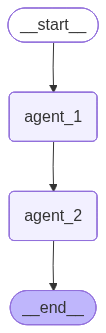

In [72]:
graph = workflow.compile()

print(type(graph))
graph

In [73]:
mermaid_code = graph.get_graph().draw_mermaid()
print(mermaid_code)

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	agent_1(agent_1)
	agent_2(agent_2)
	__end__([<p>__end__</p>]):::last
	__start__ --> agent_1;
	agent_1 --> agent_2;
	agent_2 --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



In [74]:
# Graph 호출하기
query = "LangGraph는 무엇이며, LangChain과 어떤 차이점이 있나요? 그리고 LangGraph를 사용해야 하는 이유는 무엇인가요?"

state = {"query": query}
result = graph.invoke(state)
print(result)


[Agent 1] 원본 질문: LangGraph는 무엇이며, LangChain과 어떤 차이점이 있나요? 그리고 LangGraph를 사용해야 하는 이유는 무엇인가요?
[Agent 1] 핵심 키워드: content='핵심 키워드:  \n1. **LangGraph**  \n2. **LangChain**  \n3. **차이점**  \n4. **사용 이유**  \n\n(추가 가능 키워드: **워크플로우 관리**, **상태 기반 대화**)  \n\n요약:  \n- **LangGraph**와 **LangChain**의 관계 및 **차이점**을 묻고, **사용 이유**를 탐구하는 질문입니다.  \n- LangGraph는 상태(state) 기반의 복잡한 워크플로우 관리에 특화된 도구이며, LangChain은 모듈형 LLM 애플리케이션 구축에 중점을 둡니다.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 111, 'prompt_tokens': 49, 'total_tokens': 160, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'solar-pro2-250909', 'system_fingerprint': None, 'id': 'aedd4a38-d00d-46e4-8ae5-8143d1f1b7c0', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None} id='run--736792c4-3f4d-4204-9435-f9f116a0ee67-0' usage_meta

In [75]:
pprint(result)

{'final_answer': AIMessage(content='### **LangGraph vs. LangChain: 핵심 차이점과 사용 이유**\n\n#### 1. **LangGraph란?**  \nLangGraph는 **LangChain의 확장 프레임워크**로, **상태(state) 기반의 복잡한 워크플로우 관리**에 특화된 도구입니다.  \n- **그래프 기반 아키텍처**를 사용해 다단계 대화, 조건부 분기, 상태 추적이 필요한 시스템을 구축합니다.  \n- 예시: 여행 예약 봇, 의료 증상 체크봇, 법적 상담 봇과 같이 **사용자 입력에 따라 동적으로 흐름이 변경되는 애플리케이션**에 적합합니다.  \n\n#### 2. **LangChain vs. LangGraph: 주요 차이점**  \n| **기준**               | **LangChain**                          | **LangGraph**                          |\n|------------------------|----------------------------------------|----------------------------------------|\n| **주요 목적**          | 단일/간단한 체인(Chain) 구성          | 복잡한 상태 머신(State Machine) 구축   |\n| **대화 처리**          | 단일 턴 또는 선형적 다단계 대화        | 장기간 상태 유지 및 동적 분기          |\n| **워크플로우 구조**    | 선형적 또는 분기형 체인                | 그래프 기반 상태 전이 (노드/엣지)      |\n| **상태 관리**          | 외부 메모리(예: `ConversationBufferMemory`) 의존 | 내장된 상태 객체(`State`)로 명시적 관리 |\n| **사용 사례**          | Q&A 챗봇, 문서 요약       

In [76]:

pprint(result['final_answer'].content)

('### **LangGraph vs. LangChain: 핵심 차이점과 사용 이유**\n'
 '\n'
 '#### 1. **LangGraph란?**  \n'
 'LangGraph는 **LangChain의 확장 프레임워크**로, **상태(state) 기반의 복잡한 워크플로우 관리**에 특화된 '
 '도구입니다.  \n'
 '- **그래프 기반 아키텍처**를 사용해 다단계 대화, 조건부 분기, 상태 추적이 필요한 시스템을 구축합니다.  \n'
 '- 예시: 여행 예약 봇, 의료 증상 체크봇, 법적 상담 봇과 같이 **사용자 입력에 따라 동적으로 흐름이 변경되는 애플리케이션**에 '
 '적합합니다.  \n'
 '\n'
 '#### 2. **LangChain vs. LangGraph: 주요 차이점**  \n'
 '| **기준**               | **LangChain**                          | '
 '**LangGraph**                          |\n'
 '|------------------------|----------------------------------------|----------------------------------------|\n'
 '| **주요 목적**          | 단일/간단한 체인(Chain) 구성          | 복잡한 상태 머신(State '
 'Machine) 구축   |\n'
 '| **대화 처리**          | 단일 턴 또는 선형적 다단계 대화        | 장기간 상태 유지 및 동적 '
 '분기          |\n'
 '| **워크플로우 구조**    | 선형적 또는 분기형 체인                | 그래프 기반 상태 전이 (노드/엣지)      '
 '|\n'
 '| **상태 관리**          | 외부 메모리(예: `ConversationBufferMemory`) 의존 | 내장된 상태 '
 '객체(`State`)로 명시적 관리 